In [96]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


CAM_FILE = "duck_data.txt"
ROBOT_FILE = "robot_position_data.txt"

def get_data(filename):
    data = []
    with open(filename, "r") as duck_file:
        lines = duck_file.readlines()[2:]
        for line in lines:
            values = line.split()
            values = [float(x) for x in values]
            data.append(values)
    
    return np.array(data)

def get_start_time(filename):
    with open(filename, "r") as duck_file:
        line = duck_file.readline()
        time = line.split()[-1]
    
    return float(time)

cam_data = get_data(CAM_FILE)
robot_data = get_data(ROBOT_FILE)


In [97]:
# convert numpy arrays to dataframes to make them easier to work with
cam_df = pd.DataFrame({
    "time": cam_data[:, 0], 
    "x": cam_data[:, 3],
    "y": cam_data[:, 4]
})

robot_df = pd.DataFrame({
    "time": robot_data[:, 0], 
    "x": robot_data[:, 1],
    "y": robot_data[:, 2]
})

In [98]:
# robot started moving after camera started, so we 
# need to normalize the times 
cam_start = get_start_time(CAM_FILE)
robot_start = get_start_time(ROBOT_FILE)
discrepancy = robot_start - cam_start
cam_df["time"] -= discrepancy 
cam_df = cam_df[cam_df["time"] > 0]  

In [99]:
# since each dataframe has a different number of rows, 
# we need to align the times into buckets
bins = pd.interval_range(
    start=min(cam_df["time"].min(), robot_df["time"].min()), 
    end=max(cam_df["time"].max(), robot_df["time"].max()), 
    periods=100
)
cam_df["bucket"] = pd.cut(cam_df["time"], bins=bins)
robot_df["bucket"] = pd.cut(robot_df["time"], bins=bins)

# merge the dataframes
merged_df = pd.merge(cam_df, robot_df, on="bucket", suffixes=("_cam", "_robot"))
merged_df = merged_df[["bucket", "x_cam", "y_cam", "x_robot", "y_robot"]]
merged_df.drop_duplicates(inplace=True)
merged_df.reset_index(inplace=True, drop=True)

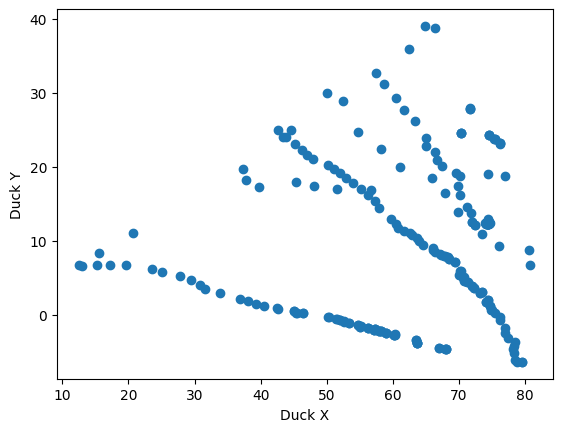

In [100]:
merged_df["x_global"] = merged_df["x_robot"] + merged_df["x_cam"]
merged_df["y_global"] = merged_df["y_robot"] + merged_df["y_cam"] 

plt.scatter(merged_df["x_global"], merged_df["y_global"])
plt.xlabel("Duck X")
plt.ylabel("Duck Y")
plt.show()